In [ ]:
#Install required library
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.8 MB/s 


## **Importing Libraries / Dataset**

> Indented block



In [ ]:
#Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge ,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.metrics import explained_variance_score

from skopt import BayesSearchCV

from math import sqrt
from time import time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import Datasets
'''
Public dataset can be downloaded from: https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting
'''

from google.colab import files
 
uploaded = files.upload()

Saving fulfilment_center_info.csv to fulfilment_center_info.csv
Saving meal_info.csv to meal_info.csv
Saving train.csv to train.csv
Saving test.csv to test.csv


In [ ]:
import io
 
df_fulfilment_center_info = pd.read_csv(io.BytesIO(uploaded['fulfilment_center_info.csv']))
df_meal_info = pd.read_csv(io.BytesIO(uploaded['meal_info.csv']))
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))



## **Data Exploration**

**Problem definition**

The datasets are for a meal delivery company which operates in multiple cities. They have various fulfillment centers or outlets in these cities for dispatching meal orders to their customers. The client wants a predictive model to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly. The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance to avoid wastage and losses.


**Features description for df_train dataset**

id: Unique ID for each record

week: Week No (A total of 145 weeks sales data for analysis)

center_id: Unique ID for fulfillment center or outlet

meal_id: Unique ID for Meal Product

checkout_price: Final sales price including discount, taxes & delivery charges

base_price: Base price of a meal product which will apply in all outlets the product has been assigned to, unless a different checkout price has been set for the outlet.

emailer_for_promotion: Emailer sent for promotion or advertisement of meal product

homepage_featured: Meal product featured on homepage of company website

num_orders: Number of orders (Target Variable)



**Features description for df_fulfilment_center_info dataset**

center_id: Unique ID for fulfillment center or outlet

city_code: Unique code for city

region_code: Unique code for region

center_type: Anonymized center type

op_area: Area of operation (in km^2)



**Features description for df_meal_info dataset**

meal_id: Unique ID for the meal product

category: Type of meal (beverages/snacks/soups etc)

cuisine: Meal cuisine (Indian/Italian etc)

In [ ]:
# Preview the fulfilment_center_info dataset
df_fulfilment_center_info.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [ ]:
# Preview the meal_info dataset
df_meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [ ]:
# Preview the train dataset
df_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [ ]:
# Preview the test dataset
# The target variable 'num_orders' is not provided with this test dataset so it can be used for accessing hackathon competition by the data providers
# As such we will derive our own test set from the train data set to demonstrate prediction accuracy of our models
df_test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [ ]:
# Merge datasets

# Data for our analysis available in 3 datasets: df_train, df_fulfilment_center_info and df_meal_info 

# Merge df_train and df_fulfilment_center_info 
df_fulfilment_train = pd.merge(df_train, df_fulfilment_center_info, on='center_id')
df_fulfilment_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0


In [ ]:
# Merge df_meal_info to the rest of training data 
df = pd.merge(df_fulfilment_train, df_meal_info, on='meal_id')
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [ ]:
# Check basic information of the dataset features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  object 
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  object 
 14  cuisine                456548 non-nu

In [ ]:
# Check statistical description of the dataset features
df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


In [ ]:
# Check number of rows and column
df.shape

(456548, 15)

In [ ]:
#Check for Null values
df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

In [ ]:
#Check number of unique values for each column
df.nunique()

id                       456548
week                        145
center_id                    77
meal_id                      51
checkout_price             1992
base_price                 1907
emailer_for_promotion         2
homepage_featured             2
num_orders                 1250
city_code                    51
region_code                   8
center_type                   3
op_area                      30
category                     14
cuisine                       4
dtype: int64

In [ ]:
#Check for duplicate records
df[df.duplicated()]


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine


In [ ]:
# Separate Numerical and Categorical data for analysis
# Caegorical Data: center_type, category & cuisine are of oject type

df_copy = df.copy()

df_cat = df_copy[['center_type','category','cuisine','emailer_for_promotion','homepage_featured']]
df_num = df_copy[['checkout_price','base_price', 'week']]

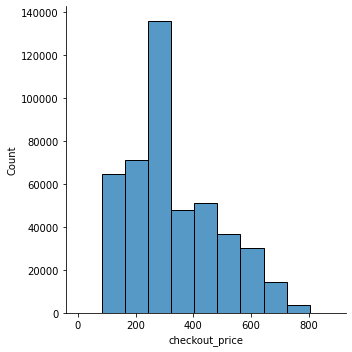

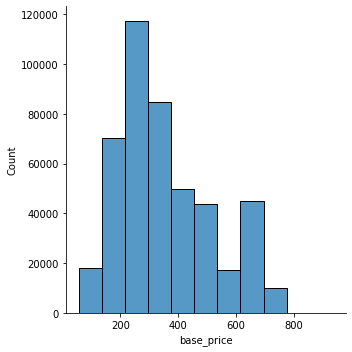

In [ ]:
#Histograms of numeric variables except the 'week' variable which is a counter

for i in df_num.columns:
  sns.displot(df_num[i],binwidth=80)
  if i == 'base_price':
      break

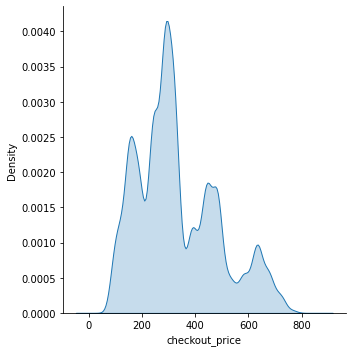

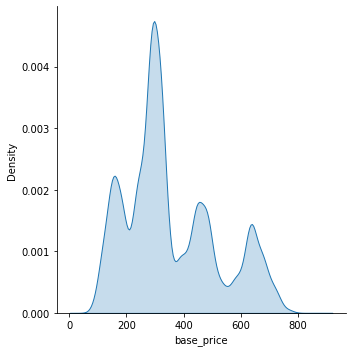

In [ ]:
#KDE of numeric variables exculding the 'week' feature which is a counter

for i in df_num.columns:
  sns.displot(df_num[i],kind="kde",bw_adjust=1.5, fill=True)
  if i == 'base_price':
      break


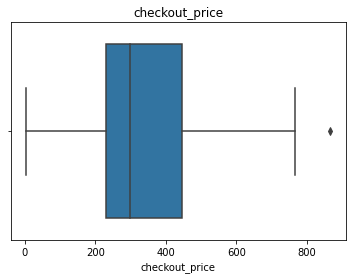

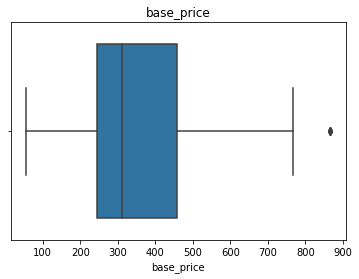

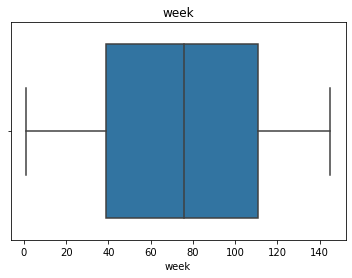

In [ ]:
#Boxplot of numeric variables

for i in df_num.columns:
  sns.boxplot(df_num[i])
  plt.title(i)
  plt.show()

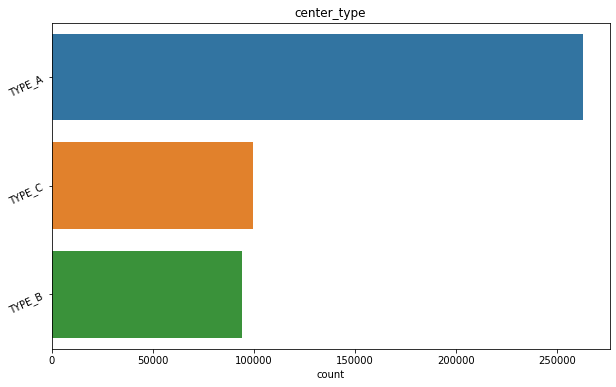

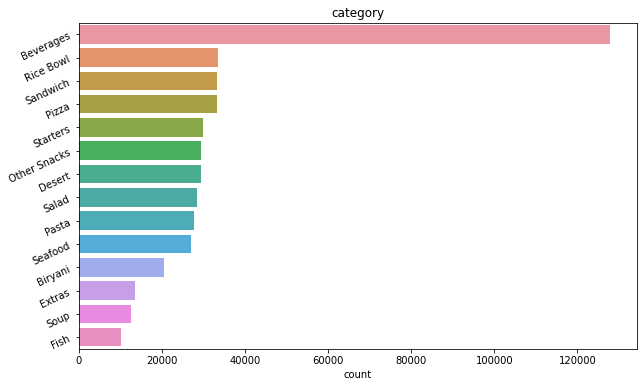

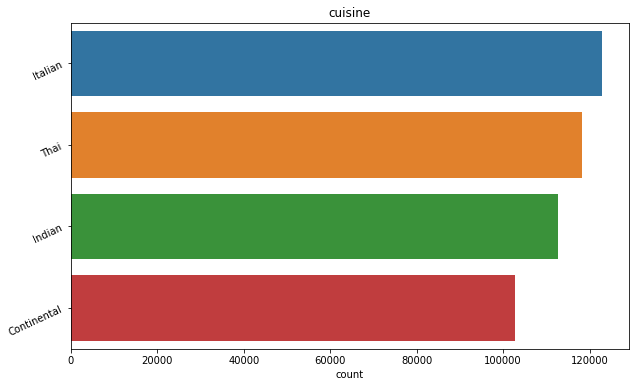

In [ ]:
#Barplot of categorical variables exculding 'emailer_for_promotion' and 'homepage_featured' which are binary encoded

for i in df_cat.columns:
    plt.figure(figsize = (10,6))
    plt.yticks(rotation=25)
    sns.barplot(df_cat[i].value_counts(),df_cat[i].value_counts().index).set_title(i)
    plt.xlabel('count')
    plt.show()
    if i == 'cuisine':
      break
     


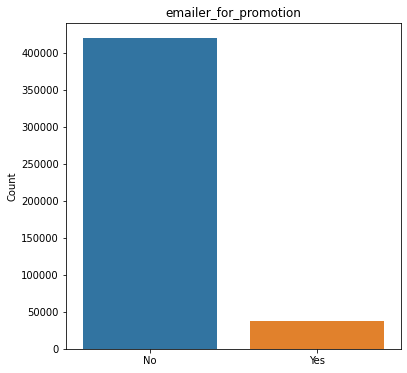

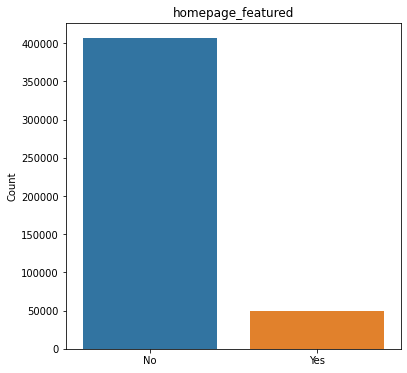

In [ ]:
#Barplot of  'emailer_for_promotion' and 'homepage_featured' features

df_bin = df_copy[['emailer_for_promotion','homepage_featured']]

for i in df_bin.columns:
    plt.figure(figsize = (6,6))
    sns.barplot(df_bin[i].value_counts().index,df_bin[i].value_counts()).set_title(i)
    plt.xticks(np.arange(2), ['No', 'Yes'])
    plt.ylabel('Count')
    plt.show()


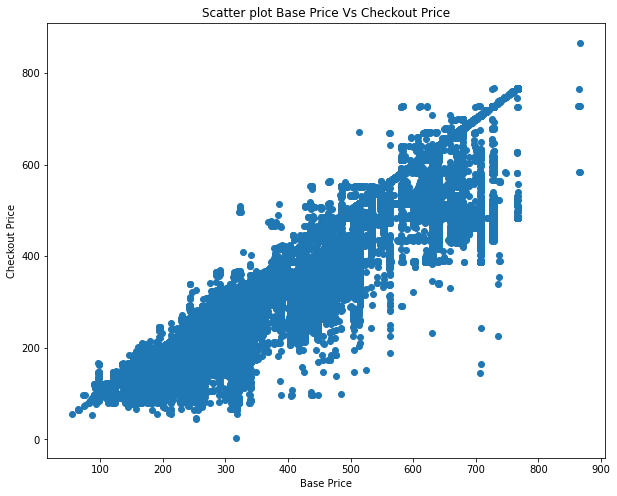

In [ ]:
#Scatter plot Base Price Vs Checkout Price
plt.figure(figsize = (10,8))
plt.scatter(df['base_price'], df['checkout_price'])
plt.title('Scatter plot Base Price Vs Checkout Price')
plt.xlabel('Base Price')
plt.ylabel('Checkout Price')
plt.show()

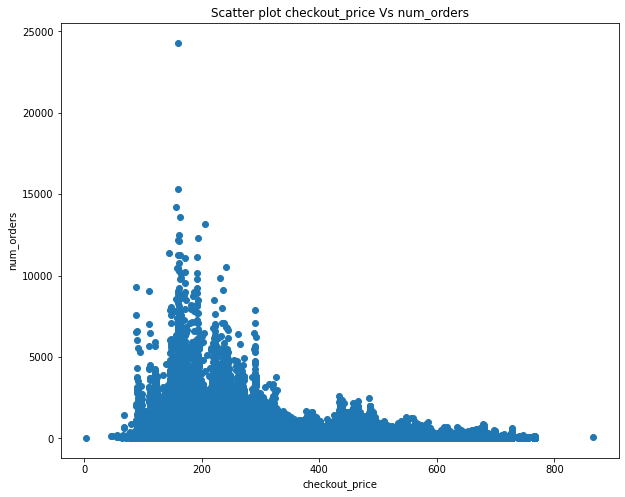

In [ ]:
#Scatter plot checkout_price Vs num_orders
plt.figure(figsize = (10,8))
plt.scatter(df['checkout_price'], df['num_orders'])
plt.title('Scatter plot checkout_price Vs num_orders')
plt.xlabel('checkout_price')
plt.ylabel('num_orders')
plt.show()

In [ ]:
# Distibution of data from scatter plot shows presence of outliers in 'checkout_price' and 'num_orders' 
# also confirmed by distribution in df.describe()

df[df['checkout_price'] > 800]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
273770,1213267,135,93,1445,866.27,866.27,0,0,94,461,34,TYPE_A,3.9,Seafood,Continental


In [ ]:
df[df['num_orders'] > 20000]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
137437,1452474,5,43,2290,159.08,311.43,1,1,24299,590,56,TYPE_A,5.1,Rice Bowl,Indian


##**Data Preprocessing**

In [ ]:
# Detection & Removal of Outlier
# IQR
Q1 = np.percentile(df['checkout_price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['checkout_price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['checkout_price'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['checkout_price'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

Old Shape:  (456548, 15)
New Shape:  (456547, 15)


In [ ]:
# Detection & Removal of Outlier
# IQR
Q1 = np.percentile(df['num_orders'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['num_orders'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['num_orders'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['num_orders'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

Old Shape:  (456547, 15)
New Shape:  (423246, 15)


In [ ]:
#Drop redundant 'id' column
df = df.drop('id', axis=1)
df.shape

(423246, 14)

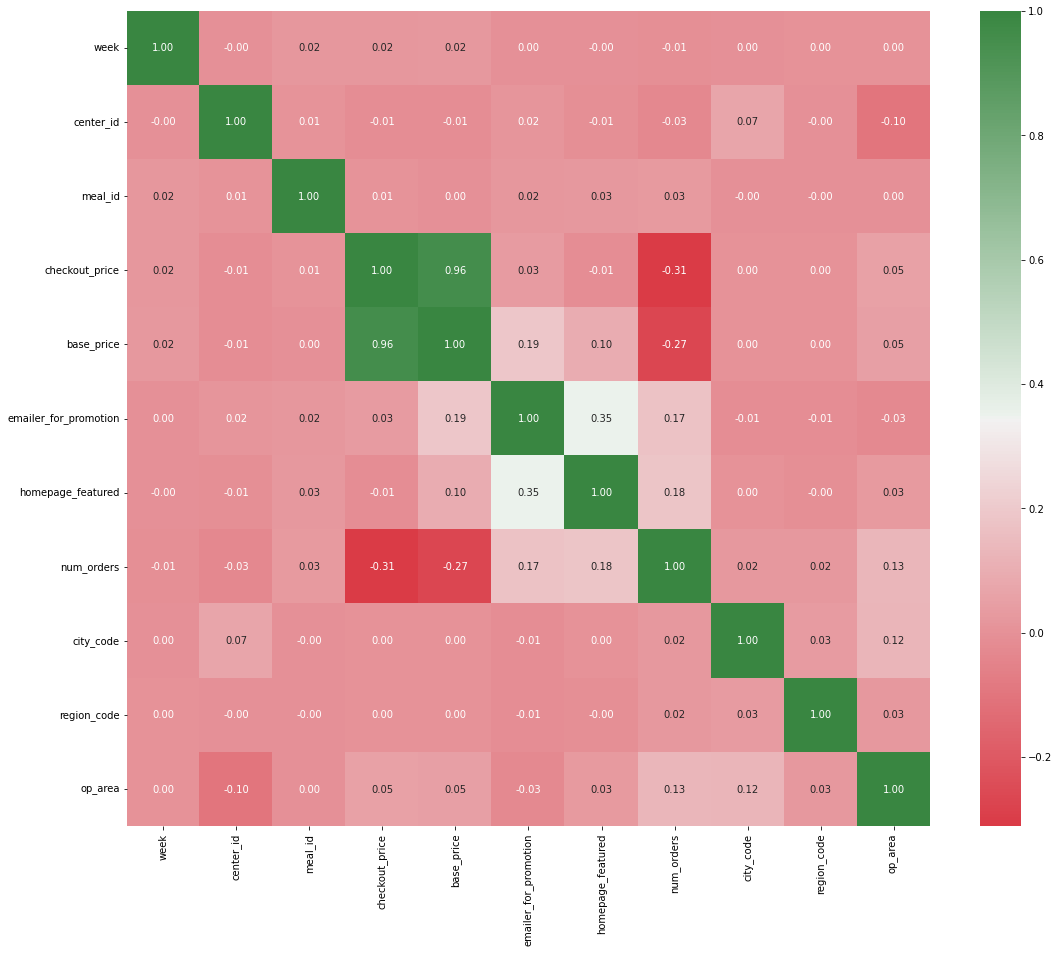

In [ ]:
# Heatmap showing corellation of variables
# High correlation noticed between base price and checkout price
#cmap="cividis"
plt.figure(figsize=(18,15))
c=df.corr()
cmap = sns.diverging_palette(10, 130, as_cmap=True)
sns.heatmap(c,cmap=cmap,annot=True,fmt='.2f')

In [ ]:
#Change categorical variables to numeric with OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='int')
ohe.fit(df[['center_type', 'category', 'cuisine']])

def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[['center_type', 'category', 'cuisine']]), columns=ohe.get_feature_names_out())
    df.drop(columns=['center_type', 'category', 'cuisine'], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

df = get_ohe(df)
df.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1,55,1885,136.83,152.29,0,0,177,647,56,...,0,0,0,0,0,0,0,0,0,1
1,2,55,1885,135.83,152.29,0,0,323,647,56,...,0,0,0,0,0,0,0,0,0,1
2,3,55,1885,132.92,133.92,0,0,96,647,56,...,0,0,0,0,0,0,0,0,0,1
3,4,55,1885,135.86,134.86,0,0,163,647,56,...,0,0,0,0,0,0,0,0,0,1
4,5,55,1885,146.50,147.50,0,0,215,647,56,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Check new columns created
df.columns

Index(['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'op_area', 'center_type_TYPE_A', 'center_type_TYPE_B',
       'center_type_TYPE_C', 'category_Beverages', 'category_Biryani',
       'category_Desert', 'category_Extras', 'category_Fish',
       'category_Other Snacks', 'category_Pasta', 'category_Pizza',
       'category_Rice Bowl', 'category_Salad', 'category_Sandwich',
       'category_Seafood', 'category_Soup', 'category_Starters',
       'cuisine_Continental', 'cuisine_Indian', 'cuisine_Italian',
       'cuisine_Thai'],
      dtype='object')

In [ ]:
# Check new shape of dataframe
df.shape

(423246, 32)

In [ ]:
#Traning and Testing data spliting
X = df.drop('num_orders', axis=1)
y = df['num_orders']

In [ ]:
#Check shape of predictor variables
X.shape

(423246, 31)

In [ ]:
#Check shape of target variable
y.shape

(423246,)

In [ ]:

#Perform Scaling and keep column names
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_Scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)



In [ ]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y, test_size=0.3, random_state=43)

##**Model Training and Evaluation**

In [ ]:
# Collating regressor models 
regressor_models = {
    'Linear Regression': {
        'regressor': LinearRegression()
    },
    'Decision Tree Regressor' : {
        'regressor': DecisionTreeRegressor()
    },
    'Random Forest Regressor': {
        'regressor': RandomForestRegressor()  
    },
    'Gradient Boosting Regressor': {
        'regressor': GradientBoostingRegressor()  
    },
     'Lasso Regressor': {
        'regressor': Lasso()  
    },
    'Ridge Regressor': {
        'regressor': Ridge()  
    },
  
}

In [ ]:
#Evaluate regressors with scoring metrics

model_columns = []
model_compare = pd.DataFrame(columns = model_columns)
row_index = 0

for model_name, model in regressor_models.items():

    model = model.get('regressor')
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start 

    model_compare.loc[row_index, 'ModelName'] = model_name
    model_compare.loc[row_index, 'Training time'] = train_time
    model_compare.loc[row_index, 'Prediction time'] = predict_time
    model_compare.loc[row_index, 'RMSE Score'] = sqrt(mean_squared_error(y_test, y_pred))
    model_compare.loc[row_index, 'MSE Score'] = mean_squared_error(y_test, y_pred)
    model_compare.loc[row_index, 'MAE Score'] = mean_absolute_error(y_test, y_pred)
    model_compare.loc[row_index, 'R2 score'] = r2_score(y_test, y_pred)   
    model_compare.loc[row_index, 'Explained variance'] = explained_variance_score(y_test, y_pred)
         
    row_index+=1   


   

In [ ]:
# Print other evaluation metrics for model comparism

model_compare.sort_values(by = ['RMSE Score'], inplace = True) 
model_compare.reset_index(drop=True, inplace=True)
model_compare

,ModelName,Training time,Prediction time,RMSE Score,MSE Score,MAE Score,R2 score,Explained variance
0,Random Forest Regressor,238.915548,11.457952,78.543218,6169.037094,51.136559,0.808676,0.808684
1,Decision Tree Regressor,3.531552,0.146776,107.360336,11526.241782,67.355569,0.642530,0.642534
2,Gradient Boosting Regressor,64.333959,0.240363,114.455953,13100.165267,79.044378,0.593716,0.593717
3,Linear Regression,0.517635,0.010717,126.841291,16088.713073,88.290254,0.501031,0.501031
4,Ridge Regressor,0.130152,0.008289,126.841337,16088.724816,88.293207,0.501030,0.501031
5,Lasso Regressor,8.273911,0.008890,127.187945,16176.773366,88.420291,0.498300,0.498300


#####**Best Baseline Resgressor Model is Random Forest Regressor with RMSE Score of 78.6**

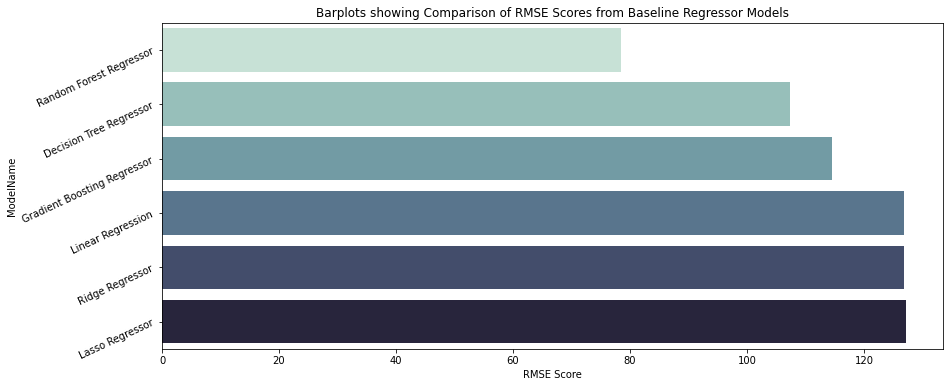

In [ ]:
# Barplots showing Comparison of RMSE Scores from Baseline Regressor Models

plt.figure(figsize = (14,6))
sns.barplot(x=model_compare['RMSE Score'],
            y=model_compare['ModelName'], data=model_compare,
            order=model_compare.sort_values('RMSE Score').ModelName,
            palette="ch:start=.2,rot=-.39")
plt.title('Barplots showing Comparison of RMSE Scores from Baseline Regressor Models')
plt.yticks(rotation=25)
plt.show()

In [ ]:
#Best Performing model so far is Random Forest Regressor with RMSE Score of 78.6

#Peform Feature Selection using Random Forest Regressor feature importance to improve preformance

rfr = RandomForestRegressor(random_state=0)

rfr.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

#####**Feature Selection with Random Forest Feature Importance**

Text(0.5, 0, 'Random Forest Feature Importance')

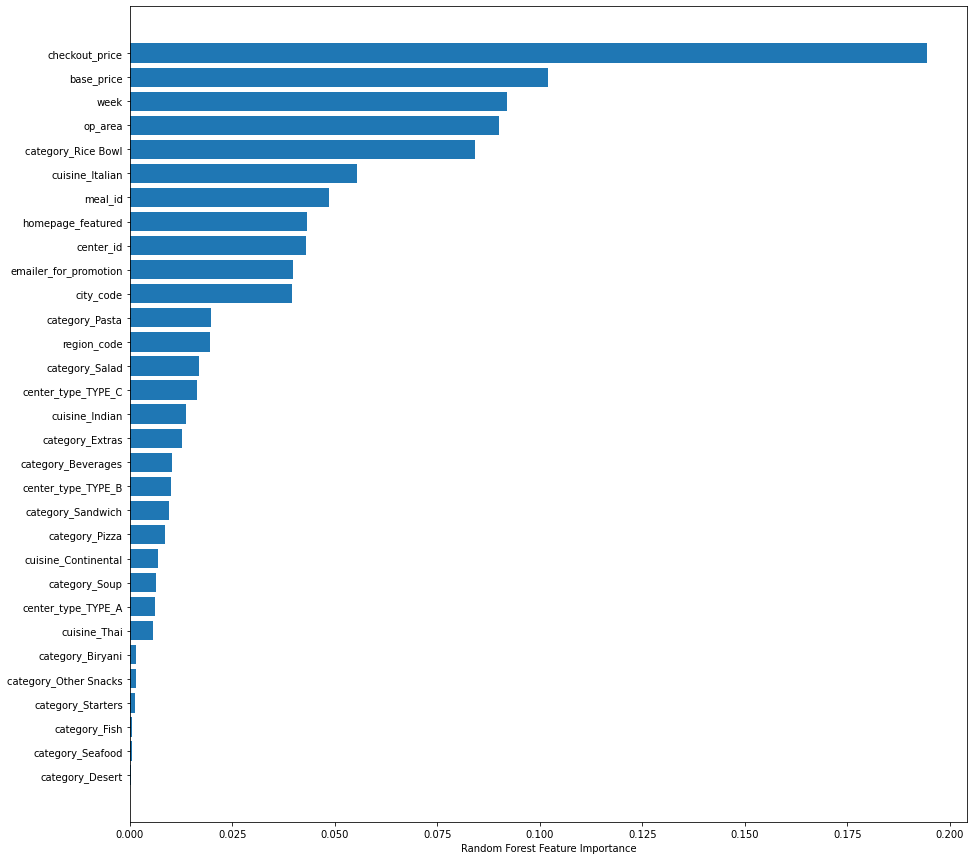

In [ ]:
#Plot feature importance

sorted_idx = rfr.feature_importances_.argsort()
plt.figure(figsize = (15,15))
plt.barh(X_train.columns[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
# select features that have an importance of more than 0.005 (threshold removes least important 6 features)

select = SelectFromModel(rfr,threshold=0.005)
select.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(random_state=0),
                threshold=0.005)

In [ ]:
# get the name of the features selected

select.get_feature_names_out()

array(['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'op_area', 'center_type_TYPE_A',
       'center_type_TYPE_B', 'center_type_TYPE_C', 'category_Beverages',
       'category_Extras', 'category_Pasta', 'category_Pizza',
       'category_Rice Bowl', 'category_Salad', 'category_Sandwich',
       'category_Soup', 'cuisine_Continental', 'cuisine_Indian',
       'cuisine_Italian', 'cuisine_Thai'], dtype=object)

In [ ]:
# make a list and count the selected features.
selected_feat= X_train.columns[(select.get_support())]
len(selected_feat)

25

In [ ]:
#Retain only selected features

X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)


#Print shape of training and test datasets before and after feature selection
print(X_train_sel.shape, X_train.shape)
print(X_test_sel.shape, X_test.shape)

(296272, 25) (296272, 31)
(126974, 25) (126974, 31)


#####**Model enhancement with hyperparameter tuning using bayesian optimization search**

In [ ]:
#Explore hyperparameter tunning for top three models

# Collating model hyperparameters 
model_params = {
    
    'Random Forest Regressor': {
        'model': RandomForestRegressor(),
        'params' : {
            'max_depth': (10,12),
            'n_estimators': (150,300),
            'max_features': ('auto','sqrt', 'log2')
        }  
    },
    'Decision Tree Regressor' : {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': (10,12),
            'splitter' : ('best','random'),
            'max_features': ('auto','sqrt', 'log2')
        }
    },
    'Gradient Boosting Regressor': {
        'model': GradientBoostingRegressor(),
        'params' : {
            'max_depth': (10,12),
            'n_estimators': (150,300),
            'max_features': ('auto','sqrt', 'log2')
        }  
    }
    
}

In [ ]:
# Use Bayesian optimization search for hyperparameters tuning
# (because of the large size of the dataset gridsearhcv is too resourse intensive)


best_params = []
row_index = 0
scoring = 'neg_mean_absolute_error' 


#Apply BayesSearchCV and Collate Metrics for Evaluating Models
for model_name, mp in model_params.items():
    opt =  BayesSearchCV(mp['model'], mp['params'], n_jobs=-1,  cv=3, n_iter=3, scoring = scoring,random_state=42)
    rgr_model = opt.fit(X_train_sel,y_train)

    # Collate Metrics for Evaluating Models
    best_params.append({
        'ModelName': model_name,
        'BestParams': rgr_model.best_params_,
        'BestScore': abs(rgr_model.best_score_)
    })
          
    row_index+=1



In [ ]:
# Print model performance and best hyperparameters
pd.set_option('max_colwidth', None)
pfm = pd.DataFrame(best_params,columns=['ModelName','BestParams','BestScore']).sort_values(by=['BestScore'])
pfm.reset_index(drop=True, inplace=True)
pfm

,ModelName,BestParams,BestScore
0,Gradient Boosting Regressor,"{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 196}",49.039634
1,Random Forest Regressor,"{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 196}",67.455033
2,Decision Tree Regressor,"{'max_depth': 12, 'max_features': 'sqrt', 'splitter': 'best'}",75.925465


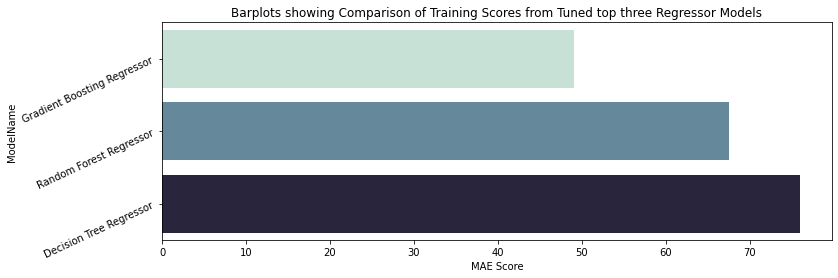

In [ ]:
# Barplots showing Comparison of Training MAE Scores from Regressor Models after Hyperameter Tuning and Feature Selection 

# Plot Barplots
plt.figure(figsize = (12,4))
sns.barplot(x=pfm['BestScore'],
            y=pfm['ModelName'], data=pfm,
            order=pfm.sort_values('BestScore').ModelName,
            palette="ch:start=.2,rot=-.39")
plt.title('Barplots showing Comparison of Training Scores from Tuned top three Regressor Models')
plt.xlabel('MAE Score')
plt.yticks(rotation=25)
plt.show()

In [ ]:

# Best model suggested after hyperparameter tuning is Gradient Boosting Regressor
# Create new Gradient Boosting Regressor with suggested hyperparameters
XGB_reg_model = GradientBoostingRegressor(random_state=25,max_depth=12,n_estimators=196,max_features='sqrt')
XGB_reg_model.fit(X_train_sel,y_train)

#Predict outcome from test set using new model
y_pred = XGB_reg_model.predict(X_test_sel)



In [ ]:

#Print test scores from comparing predicted outcome with unseen data 
#(Better RMSE Scores was derived after feature selection and hyperparameter tuning)
print("R2 score  :",r2_score(y_test, y_pred))
print("MAE score : ",mean_absolute_error(y_test, y_pred))
print("MSE score  :",mean_squared_error(y_test, y_pred))
print("RMSE score : ",sqrt(mean_squared_error(y_test, y_pred)))



R2 score  : 0.8385040713519892
MAE score :  47.880543884323046
MSE score  : 5207.258805202789
RMSE score :  72.16133871542841


#####**Best model suggested after hyperparameter tuning is Gradient Boosting Regressor**
#####**Enhanced Model's RMSE Score reduced to 72.16**
